In [1]:
import numpy as np
from typing import List, Dict, Tuple, Union
from numpy.typing import ArrayLike
from nn import *
import matplotlib.pyplot as plt

In [2]:
#read in fasta files

positives = read_text_file('data/rap1-lieb-positives.txt')
negatives = read_fasta_file('data/yeast-upstream-1k-negative.fa')

In [3]:
#get length of the positive sequences
new_negatives_len = len(positives[0])

In [4]:
import random

# Randomly sample a substring of the same length of positive sequence from each negative sequence
negative_seqs_trimmed = [
    seq[random_start: random_start + new_negatives_len]  #get sequence starting from random start + length of the positive sequence
    if len(seq) > new_negatives_len else seq 
    for seq in negatives
    for random_start in [random.randint(0, len(seq) - new_negatives_len)]  # Assign random_start first to any number that's within the len of positive sequence
]


seqs_combined = positives + negative_seqs_trimmed #add the positive and negative datasets together
classifications = [1] * len(positives) + [0] * len(negative_seqs_trimmed) #assign classifications with 1 = True and 0 = False for Rap1 binding sit

In [5]:
import nn.preprocess as preprocess

#randomly sample from positive group w replacement to balance sample numbers
random_seqs, random_labels = preprocess.sample_seqs(seqs_combined, classifications)

#one-hot encodes the lists of DNA sequences
seqs_one_hot = preprocess.one_hot_encode_seqs(random_seqs)

Rationale for sampling scheme:

To deal with the class imbalance in the dataset, the negative sequences, since they were much longer, were first truncated to the same length as the positive sequences so that they could be compared. A sequence of 17 base pairs were sampled from the negative sequences at random, starting from a random location 17 or more basepairs away from the end of each sequence. This was to decrease the bias that might arise from sampling in the same location (the beginning of the sequence) every time. 

To give the model equal exposure to both positive and negative classes to aid training, sequences were selected with replacement to match the most prevalent class. This means that the positive samples are selected multiple times and more frequently than the negative samples. This strategy is used to balance the dataset. 

The smaller set of positive samples was oversampled to match the size of the negative samples in order to give the model more data to train with. However, this may result in inflated model performance metrics on the validation set since most if not all of the positive sequences will probably also be represented in the training set as well. 

In [7]:
from sklearn.model_selection import train_test_split

#split the data into training and test sets, using an 80/20 split 
X_train, X_test, y_train, y_test = train_test_split(seqs_one_hot, random_labels, test_size = 0.2, random_state = 42)

In [8]:
print("Training size", X_train.shape)
print("Validation size", X_test.shape)

Training size (5060, 68)
Validation size (1266, 68)


In [9]:
#generate instance of Neural Network

#architecture should take in the column dimension of the training and validation set 
nn_arch = [{'input_dim': 68, 'output_dim': 32, 'activation': 'relu'},
           {'input_dim': 32, 'output_dim': 16, 'activation': 'relu'},
           {'input_dim': 16, 'output_dim': 1, 'activation': 'sigmoid'}]


dna_network = nn.NeuralNetwork(nn_arch=nn_arch, lr=0.02, seed=42, batch_size=100, epochs=250, loss_function = "binary_cross_entropy")

Rationale for hyperparameters:

Binary cross entropy was the loss function used because that is the standard classifer used to predict binary classes. 

The sigmoid function can also be used as the activation function since it is a logistic regression function that outputs a value between [0,1] that can be converted into binary. 

I started training at 1000 epochs, since that is what was ideal for the autoencoder, but it turned out to be much more than was needed to get good accuracy and minimal loss.

I started training with the learning rate at 0.00005 as the hyperparameter that was used for the autoencoder, but this was much too small and showed very high loss and likely would've taken much too much time to converge, if it would converge at all. 0.02 was determined as a decent learning rate through trial and error, giving good accuracy with acceptable training times. 

A batch size of 100 was also sufficient to generate decent accuracy without costing too much run time

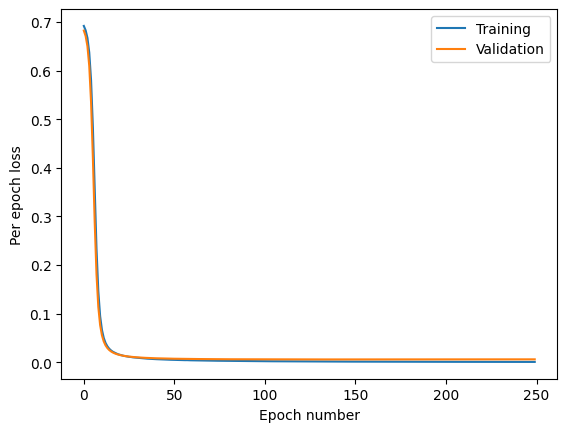

In [11]:
train_loss, val_loss = dna_network.fit(np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test))

plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(labels = ['Training', 'Validation'])
plt.xlabel('Epoch number')
plt.ylabel('Per epoch loss')
plt.show()

In [12]:
#use the built in prediction function to predict the output of the X validation set based on the model we trained using our training data
pred = dna_network.predict(X_test)

#how logistic regression chooses a binary result
pred_binary = np.where(pred > 0.5, 1, 0)

#should be close to 1 in a good model
print(f"Validation data accuracy: {np.sum(pred_binary == y_test) / len(y_test)}")

Validation data accuracy: 0.9984202211690363
